## Add library

In [52]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector

from math import sqrt

import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
%matplotlib inline

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError
from qiskit.providers.aer.noise import amplitude_damping_error

print('done!!!')

done!!!


## Schematic of proposed protocol

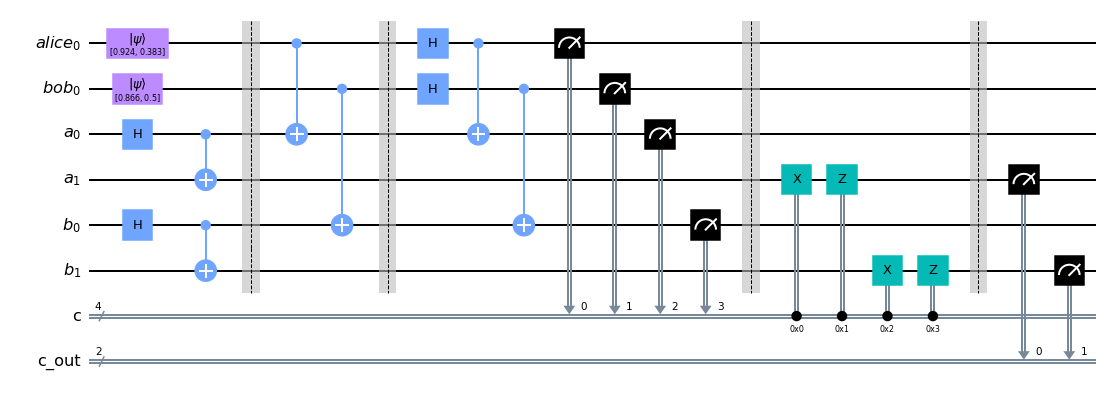

In [53]:
A = QuantumRegister(1, 'alice')
B = QuantumRegister(1, 'bob')
ch_a = QuantumRegister(2, 'a')
ch_b = QuantumRegister(2, 'b')
M = ClassicalRegister(4,'c')
M_out = ClassicalRegister(2,'c_out')
QC = QuantumCircuit(A,B,ch_a,ch_b,M,M_out)

theta_A = np.pi/4
theta_B = np.pi/3
initial_state_alice = [np.cos(theta_A/2),np.sin(theta_A/2)]
initial_state_bob   = [np.cos(theta_B/2),np.sin(theta_B/2)]

QC.initialize(initial_state_alice,A[0])
QC.initialize(initial_state_bob,B[0])
    
QC.h(ch_a[0])
QC.h(ch_b[0])
QC.cx(ch_a[0],ch_a[1])
QC.cx(ch_b[0],ch_b[1])
QC.barrier(A,B,ch_a,ch_b)

QC.cx(A[0],ch_a[0])
QC.cx(B[0],ch_b[0])
QC.barrier(A,B,ch_a,ch_b)

QC.h(A[0])
QC.h(B[0])
QC.cx(A[0],ch_a[0])
QC.cx(B[0],ch_b[0])
QC.measure(A[0],M[0])
QC.measure(B[0],M[1])
QC.measure(ch_a[0],M[2])
QC.measure(ch_b[0],M[3])
QC.barrier(A,B,ch_a,ch_b)

QC.x(ch_a[1]).c_if(M,0x0)
QC.z(ch_a[1]).c_if(M,0x1)
QC.x(ch_b[1]).c_if(M,0x2)
QC.z(ch_b[1]).c_if(M,0x3)
QC.barrier(A,B,ch_a,ch_b)

QC.measure(ch_a[1],M_out[0])
QC.measure(ch_b[1],M_out[1])


QC.draw(output='mpl')

## Define proposed protocol like a function
Inputs:

$\theta_A\text{= polar angle of alice input qubit}$

$\theta_B\text{= polar angle of bob input qubit}$

In [20]:
def protocol(theta_A,theta_B):

    alice = QuantumRegister(1, 'alice')
    bob = QuantumRegister(1, 'bob')
    a = QuantumRegister(2, 'a')
    b = QuantumRegister(2, 'b')
    c_a0 = ClassicalRegister(1,'c_a0')
    c_b0 = ClassicalRegister(1,'c_b0')
    c_a1 = ClassicalRegister(1,'c_a1')
    c_b1 = ClassicalRegister(1,'c_b1')
    c_A = ClassicalRegister(1,'c_A')
    c_B = ClassicalRegister(1,'c_B')

    circ = QuantumCircuit(alice,bob,a,b,c_a0,c_b0,c_A,c_B,c_a1,c_b1)
    initial_state_alice = [np.cos(theta_A),np.sin(theta_A)]
    initial_state_bob   = [np.cos(theta_B),np.sin(theta_B)]
    circ.initialize(initial_state_alice,alice)
    circ.initialize(initial_state_bob,bob)
    circ.h(a[0])
    circ.h(b[0])
    circ.cx(a[0],a[1])
    circ.cx(b[0],b[1])
    circ.barrier(alice,bob,a,b)
    circ.cx(alice[0],a[0])
    circ.cx(bob[0],b[0])
    circ.barrier(alice,bob,a,b)
    circ.measure(a[0],c_a0)
    circ.measure(b[0],c_b0)    
    circ.x(a[1]).c_if(c_a0, 1)
    circ.x(b[1]).c_if(c_b0, 1)
    circ.barrier(alice,bob,a,b)
    circ.h(alice)
    circ.h(bob)
    circ.measure(alice,c_A)
    circ.measure(bob,c_B)
    circ.z(a[1]).c_if(c_A, 1)
    circ.z(b[1]).c_if(c_B, 1)
    circ.barrier(alice,bob,a,b)
    circ.measure(a[1],c_a1)
    circ.measure(b[1],c_b1)
    
    return circ

## Simulation of protocol without noise effect

## Step1
$\theta_A = \frac{\pi}{4}$

$\theta_B = \frac{\pi}{3}$

In [21]:
theta_A = np.pi/4
theta_B = np.pi/3

Quantum_circuit = protocol(theta_A,theta_B)

## Step2
Simulation of quantum circuit with 'qasm_simulator'

In [22]:
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(Quantum_circuit, simulator)

# Run and get counts
result = simulator.run(circ, shots=1000).result()
counts = result.get_counts(circ)

## Step3 
Calculating of the output measurments

In [42]:
state_a0 = 0
state_a1 = 0
state_b0 = 0
state_b1 = 0
state_00 = 0
state_01 = 0
state_10 = 0
state_11 = 0
i=0

for state in counts:
    i=i+1
    if (state[0]=='0')&(state[2]=='0'):
        state_00 = counts[state]
        state_a0=state_a0+counts[state]
        state_b0=state_b0+counts[state]
    if (state[0]=='0')&(state[2]=='1'):
        state_01 = counts[state]
        state_a0=state_a0+counts[state]
        state_b1=state_b1+counts[state]
    if (state[0]=='1')&(state[2]=='0'):
        state_10 = counts[state]
        state_a1=state_a1+counts[state]
        state_b0=state_b0+counts[state]
    if (state[0]=='1')&(state[2]=='1'):
        state_11 = counts[state]
        state_a1=state_a1+counts[state]
        state_b1=state_b1+counts[state]

P_a1_0 = state_a0/1000
P_a1_1 = state_a1/1000
P_b1_0 = state_b0/1000
P_b1_1 = state_b1/1000

count_new = {'00':state_00,'01':state_01,'10':state_10,'11':state_11}
count_alice = {'0':state_a0,'1':state_a1}
count_bob = {'0':state_b0,'1':state_b1}

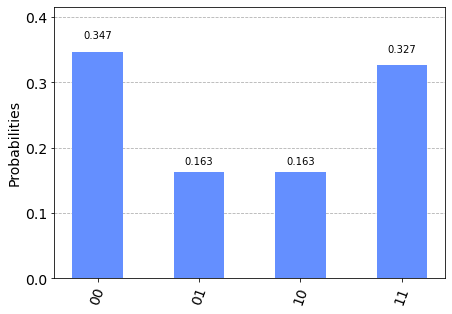

In [43]:
plot_histogram(count_new)

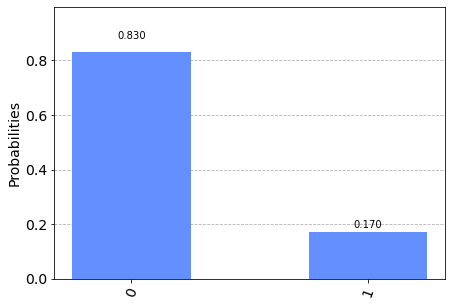

In [33]:
plot_histogram(count_alice)

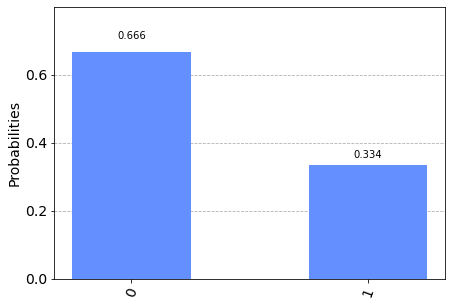

In [34]:
plot_histogram(count_bob)

## Simulation of protocol with Amplitude-damping noise effect

## Step1
Define noise model of Amplitude-damping noise with parameter noise $\eta_{AD}$

In [35]:
def noise_model(eta_AD):
    noise_AD = NoiseModel()

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = amplitude_damping_error(eta_AD, 0)

    noise_AD.add_quantum_error(error, ['id','u1','u2','u3'],[2])
    noise_AD.add_quantum_error(error, ['id','u1','u2','u3'],[3])
    noise_AD.add_quantum_error(error, ['id','u1','u2','u3'],[4])
    noise_AD.add_quantum_error(error, ['id','u1','u2','u3'],[5])

    error_2 = error.tensor(error)
    noise_AD.add_quantum_error(error_2, ['cx'],[0,2])
    noise_AD.add_quantum_error(error_2, ['cx'],[1,4])

    # Print noise model info
    return noise_AD

## Step2
$\theta_A = \frac{\pi}{4}$

$\theta_B = \frac{\pi}{3}$

In [46]:
theta_A = np.pi/4
theta_B = np.pi/3

Quantum_circuit_noisy = protocol(theta_A,theta_B)

## Step3
Simulation of quantum circuit with 'qasm_simulator' and noise model ($\eta_{AD}=0.3$)

In [47]:
noise_model_AD = noise_model(eta_AD=0.3)

sim_noise = AerSimulator(noise_model=noise_model_AD)

# Transpile circuit for noisy basis gates
Qc_noise = transpile(Quantum_circuit_noisy, sim_noise)

# Run and get counts
result = sim_noise.run(Qc_noise, shots=1000).result()
counts = result.get_counts(0)


## Step4
Calculating of the output measurments

In [48]:
state_a0 = 0
state_a1 = 0
state_b0 = 0
state_b1 = 0
state_00 = 0
state_01 = 0
state_10 = 0
state_11 = 0
i=0

for state in counts:
    i=i+1
    if (state[0]=='0')&(state[2]=='0'):
        state_00 = counts[state]
        state_a0=state_a0+counts[state]
        state_b0=state_b0+counts[state]
    if (state[0]=='0')&(state[2]=='1'):
        state_01 = counts[state]
        state_a0=state_a0+counts[state]
        state_b1=state_b1+counts[state]
    if (state[0]=='1')&(state[2]=='0'):
        state_10 = counts[state]
        state_a1=state_a1+counts[state]
        state_b0=state_b0+counts[state]
    if (state[0]=='1')&(state[2]=='1'):
        state_11 = counts[state]
        state_a1=state_a1+counts[state]
        state_b1=state_b1+counts[state]

P_a1_0 = state_a0/1000
P_a1_1 = state_a1/1000
P_b1_0 = state_b0/1000
P_b1_1 = state_b1/1000

count_new = {'00':state_00,'01':state_01,'10':state_10,'11':state_11}
count_alice = {'0':state_a0,'1':state_a1}
count_bob = {'0':state_b0,'1':state_b1}


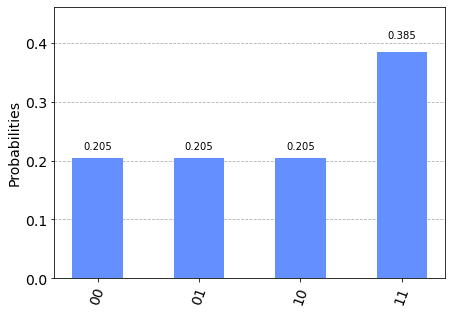

In [49]:
plot_histogram(count_new)

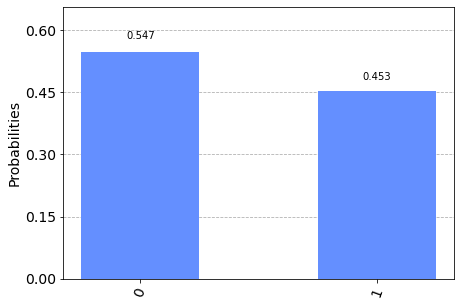

In [50]:
plot_histogram(count_alice)

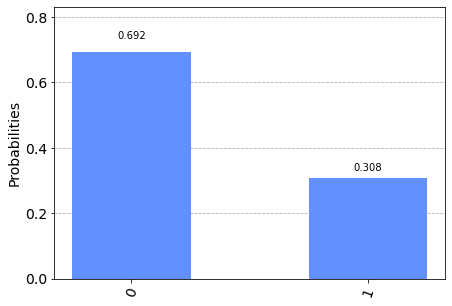

In [51]:
plot_histogram(count_bob)